In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import glob
import time 
from statsmodels.graphics.tsaplots import acf
from scipy.signal import periodogram
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import datetime
from scipy.interpolate import interp1d
from collections import OrderedDict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.colors

pd.set_option('display.max_row', 1000)

# Import data

## Test data 

In [2]:
path = "/Users/calumthompson/Documents/Final year project/Data/S&P500 1mins/*"   #put folder data is in here

data_merge = []

for fname in glob.glob(path):
    x = pd.read_csv(fname, dtype = {'<TIME>': str})
    
    data_merge.append(x)

SandP_1mins = pd.concat(data_merge)

SandP_1mins.columns = SandP_1mins.columns.str.replace("<","").str.replace(">","")

SandP_1mins['TIMESTAMP'] = SandP_1mins['DATE'].astype(str) + SandP_1mins['TIME'].astype(str)
SandP_1mins['TIMESTAMP'] = pd.to_datetime(SandP_1mins['TIMESTAMP'] ,format='%Y%m%d%H%M%S')
SandP_1mins['DATE'] = pd.to_datetime(SandP_1mins['DATE'] ,format='%Y%m%d')

SandP_1mins = SandP_1mins[['DATE','TIMESTAMP','TIME','OPEN','HIGH','LOW','CLOSE','VOL']]
SandP_1mins = SandP_1mins.sort_values('TIMESTAMP')

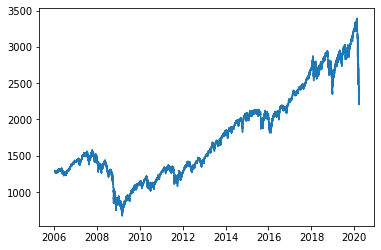

In [3]:
plt.plot(SandP_1mins['DATE'], SandP_1mins['CLOSE'])
plt.show();

## Import daily FLEs

In [4]:
daily_FLE_df = pd.read_csv('/Users/calumthompson/Documents/Final year project/Implementation/lyapunov_output/CSVs/Complete_data_S&P500.csv', parse_dates=['Date'])
daily_FLE_df['ln(close)'] = np.log(daily_FLE_df['Close price'])


## Hourly rolling average

In [5]:
path = "/Users/calumthompson/Documents/Final year project/Implementation/Hourly rolling csvs/*"   #put folder data is in here

data_merge = []

for fname in glob.glob(path):
    x = pd.read_csv(fname, parse_dates = ['period_ending'], usecols=['period_ending','lyapunov_exponent'])
    
    data_merge.append(x)
    
hourly_FLE_df = pd.concat(data_merge).sort_values(by = 'period_ending')
hourly_FLE_df = pd.merge(hourly_FLE_df,SandP_1mins, left_on = 'period_ending', right_on = 'TIMESTAMP')[['TIMESTAMP','lyapunov_exponent','OPEN']]
hourly_FLE_df['ln(close)'] = np.log(hourly_FLE_df['OPEN'])



# Identifying a crash


## Daily

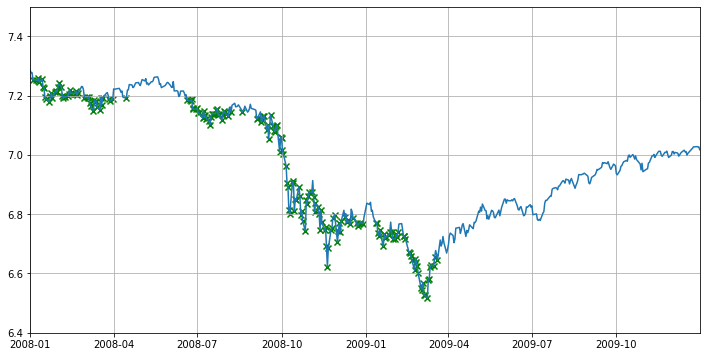

In [6]:
quantile_window = 200
quantile_value = 0.1

plt.figure(figsize = [12,6])
plt.plot(daily_FLE_df['Date'],daily_FLE_df['ln(close)'])
plt.xlim('2008-01-01','2009-12-31')
plt.ylim(6.4,7.5)
plt.grid()

daily_FLE_df['crash_threshold'] =  daily_FLE_df['ln(close)'].rolling(quantile_window).quantile(quantile_value)
daily_FLE_df['crashing'] = np.where(daily_FLE_df['ln(close)'] < daily_FLE_df['crash_threshold'], 1,0)

crash_df = daily_FLE_df.loc[daily_FLE_df['crashing'] == 1]
plt.scatter(crash_df['Date'],crash_df['ln(close)'],label = 'crashing', c = 'g', marker = 'x')


## Hourly

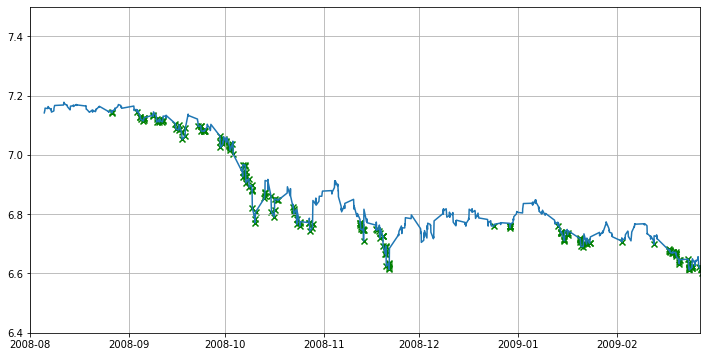

In [7]:
quantile_window = 80
quantile_value = 0.1

plt.figure(figsize = [12,6])
plt.plot(hourly_FLE_df['TIMESTAMP'],hourly_FLE_df['ln(close)'])
plt.xlim('2008-08-01','2009-02-27')
plt.ylim(6.4,7.5)
plt.grid()

hourly_FLE_df['crash_threshold'] =  hourly_FLE_df['ln(close)'].rolling(quantile_window).quantile(quantile_value)
hourly_FLE_df['crashing'] = np.where(hourly_FLE_df['ln(close)'] < hourly_FLE_df['crash_threshold'], 1,0)

crash_df = hourly_FLE_df.loc[hourly_FLE_df['crashing'] == 1]
plt.scatter(crash_df['TIMESTAMP'],crash_df['ln(close)'],label = 'crashing', c = 'g', marker = 'x')


# Daily FLEs

## Abs value vs abs FLE

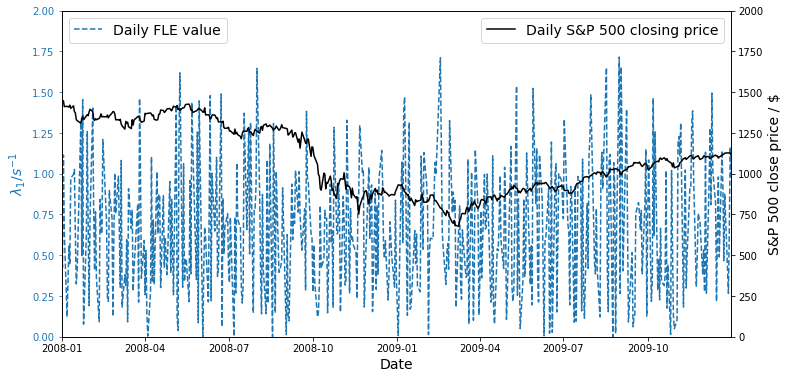

In [9]:
plot_start = pd.to_datetime('2008-01-01')
plot_end = pd.to_datetime('2009-12-31')

fig, ax1 = plt.subplots(figsize = [12,6])

ax1.set_xlim(plot_start,plot_end)
ax2 = ax1.twinx()


ax2.plot( daily_FLE_df['Date'],daily_FLE_df['Close price'], label = 'Daily S&P 500 closing price',c = 'k', zorder = 10)
ax1.plot(daily_FLE_df['Date'], daily_FLE_df['FLE'], c = 'C0', label = 'Daily FLE value' , zorder = 1, linestyle = '--')

ax1.legend(loc = 'upper left', fontsize = 14)
ax2.legend(loc = 'upper right', fontsize = 14)

ax1.set_ylim(0,2)
ax2.set_ylim(0,2000)

ax1.set_ylabel('$ \lambda_{1} / s^{-1} $', c = 'C0', fontsize = 14)
ax1.tick_params(axis='y', colors='C0')

ax2.set_ylabel('S&P 500 close price / $', fontsize = 14)
ax1.set_xlabel('Date', fontsize = 14)


fname = 'daily_raw'
plt.savefig('Figures_for_report/' + fname + '.png', dpi = 400,  bbox_inches = 'tight')


## EWMA curve in lower quantile


In [10]:
daily_FLE_df['FLE_smoothed'] = daily_FLE_df['FLE'].ewm(halflife=5).mean()

In [11]:
quantile_value = 0.1
quantile_window = 200

daily_FLE_df['threshold'] =  daily_FLE_df['FLE_smoothed'].rolling(quantile_window).quantile(quantile_value)
daily_FLE_df['Below_threshold'] = np.where(daily_FLE_df['FLE_smoothed'] < daily_FLE_df['threshold'], 1,0)

### 2008 crash

In [12]:
plot_start = '2008-01-01'
plot_end = '2009-12-31'

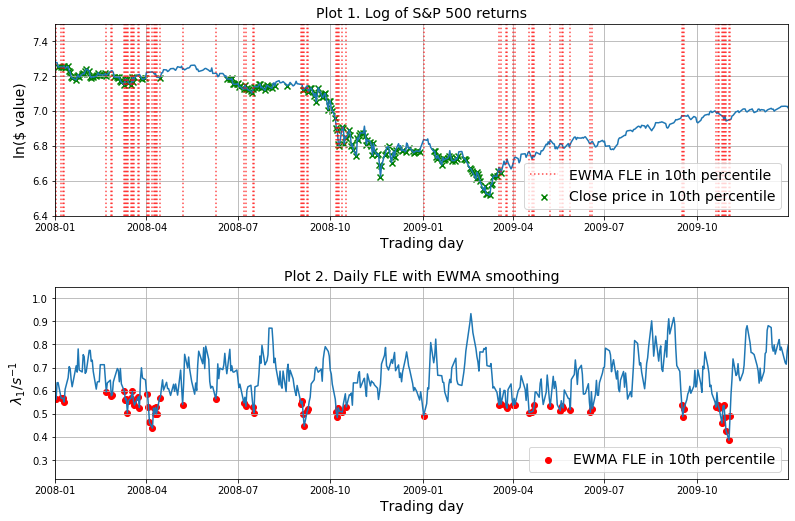

In [14]:
fig, axs = plt.subplots(2,figsize = [12,8])
fig.tight_layout(pad=5.0)
    
############# Plot 1) Log returns ###############

axs[0].set_title('Plot 1. Log of S&P 500 returns', fontsize = 14)
axs[0].plot( daily_FLE_df['Date'],np.log(daily_FLE_df['Close price']))
axs[0].set_ylabel('ln($ value)', fontsize = 14)
axs[0].set_ylim(6.4,7.5)

############# Plot 2) EWMA FLE ################

axs[1].set_title('Plot 2. Daily FLE with EWMA smoothing', fontsize = 14)
axs[1].plot( daily_FLE_df['Date'],daily_FLE_df['FLE_smoothed'])
axs[1].set_ylabel('$ \lambda_{1} / s^{-1} $', fontsize = 14)


############# Show FLE breaches ################

for i in range(0,daily_FLE_df.shape[0]):
    if daily_FLE_df.iloc[i]['Below_threshold']:
        axs[0].axvline(daily_FLE_df.iloc[i]['Date'], linestyle = ':',alpha = 0.7, c = 'r', label = 'EWMA FLE in 10th percentile')

        
low_lyapunov_data = daily_FLE_df.loc[daily_FLE_df['Below_threshold'] == 1]

axs[1].scatter(low_lyapunov_data['Date'],low_lyapunov_data['FLE_smoothed'],label = 'EWMA FLE in 10th percentile', c = 'r')
        
    
    
############# Show crashes ################

crash_df = daily_FLE_df.loc[daily_FLE_df['crashing'] == 1]
axs[0].scatter(crash_df['Date'],crash_df['ln(close)'],label = 'Close price in 10th percentile', c = 'g', marker = 'x')

############# Legends ################
   
        
handles, labels = axs[0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

axs[0].legend(by_label.values(), by_label.keys(), loc = 'lower right', fontsize = 14)

axs[1].legend(loc = 'lower right', fontsize = 14)


############# set up axes ###############

for ax in axs:
    ax.grid()
    ax.set_xlim(left = plot_start, right = plot_end)
    ax.set_xlabel('Trading day', fontsize = 14)

    
fname = 'Daily_quantiles'
plt.savefig('Figures_for_report/' + fname + '.png', dpi = 400)
    


## Whole chart 2006-2020

In [15]:
plot_start = '2006-01-01'
plot_end = '2020-03-31'

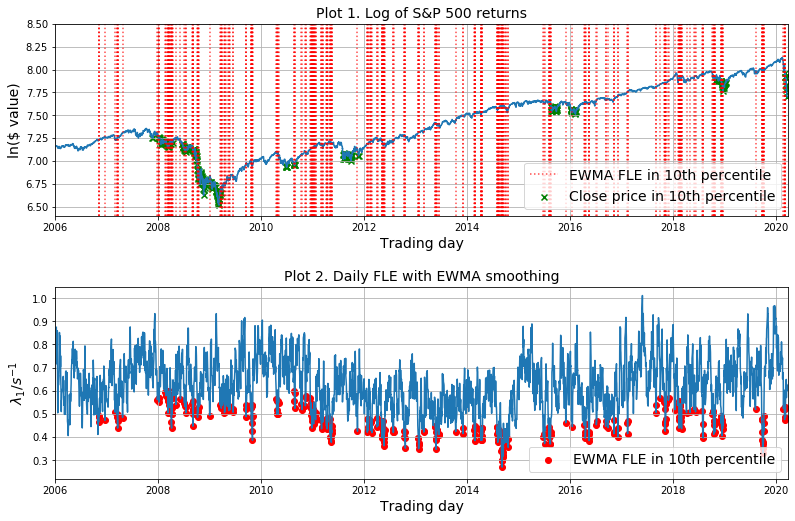

In [16]:
fig, axs = plt.subplots(2,figsize = [12,8])
fig.tight_layout(pad=5.0)
    
############# Plot 1) Log returns ###############

axs[0].set_title('Plot 1. Log of S&P 500 returns', fontsize = 14)
axs[0].plot( daily_FLE_df['Date'],np.log(daily_FLE_df['Close price']))
axs[0].set_ylabel('ln($ value)', fontsize = 14)
axs[0].set_ylim(6.4,8.5)

############# Plot 2) EWMA FLE ################

axs[1].set_title('Plot 2. Daily FLE with EWMA smoothing', fontsize = 14)
axs[1].plot( daily_FLE_df['Date'],daily_FLE_df['FLE_smoothed'])
axs[1].set_ylabel('$ \lambda_{1} / s^{-1} $', fontsize = 14)


############# Show FLE breaches ################

for i in range(0,daily_FLE_df.shape[0]):
    if daily_FLE_df.iloc[i]['Below_threshold']:
        axs[0].axvline(daily_FLE_df.iloc[i]['Date'], linestyle = ':',alpha = 0.7, c = 'r', label = 'EWMA FLE in 10th percentile')

        
low_lyapunov_data = daily_FLE_df.loc[daily_FLE_df['Below_threshold'] == 1]

axs[1].scatter(low_lyapunov_data['Date'],low_lyapunov_data['FLE_smoothed'],label = 'EWMA FLE in 10th percentile', c = 'r')
        
    
    
############# Show crashes ################

crash_df = daily_FLE_df.loc[daily_FLE_df['crashing'] == 1]
axs[0].scatter(crash_df['Date'],crash_df['ln(close)'],label = 'Close price in 10th percentile', c = 'g', marker = 'x')

############# Legends ################
   
        
handles, labels = axs[0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

axs[0].legend(by_label.values(), by_label.keys(), loc = 'lower right', fontsize = 14)

axs[1].legend(loc = 'lower right', fontsize = 14)


############# set up axes ###############

for ax in axs:
    ax.grid()
    ax.set_xlim(left = plot_start, right = plot_end)
    ax.set_xlabel('Trading day', fontsize = 14)

    
fname = 'Daily_quantiles_2006_2020'
plt.savefig('Figures_for_report/' + fname + '.png', dpi = 400)
    


## Confusion matrix 2006-2020

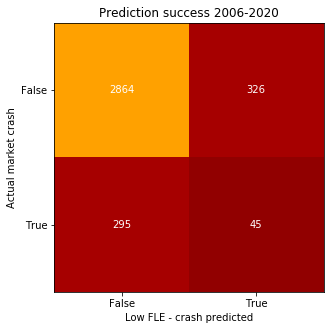

In [15]:
df_confusion = pd.crosstab(daily_FLE_df['crashing'], daily_FLE_df['Below_threshold'],  rownames=['Actual'], colnames=['Predicted'])

title='Prediction success 2006-2020'

cmap=plt.cm.get_cmap('hot', 100)
cmap = matplotlib.colors.ListedColormap(cmap(np.linspace(0.2, 0.6, 100)))

fig, ax = plt.subplots(figsize = [5,5])
fig.tight_layout(pad=3.0)
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(df_confusion, cmap=cmap)

for (i, j), z in np.ndenumerate(df_confusion):
    ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center', c = 'w')
    
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('Low FLE - crash predicted')
plt.ylabel('Actual market crash')
plt.title(title)
ax.set_xticklabels(['a','False', 'True'])
ax.set_yticklabels(['a','False', 'True'])

fname = 'Daily_confusion_matrix'
plt.savefig('Figures_for_report/' + fname + '.png', dpi = 400, bbox_inches = 'tight')

In [16]:
#sensitivity = true positives + (TP + FN)
sensitivity = df_confusion[1][1] / (df_confusion[0][1] + df_confusion[1][1])

#False positive = FP / (TP + FP)
false_positive = df_confusion[1][0] / (df_confusion[1][0] + df_confusion[1][1])

print('Sensitivity is ', sensitivity)
print('False positive rate is ', false_positive)

Sensitivity is  0.1323529411764706
False positive rate is  0.8787061994609164


# Hourly FLEs

## 2008 crash

In [31]:
start = '2008-08-04'
end = '2009-02-28'

plot_data = hourly_FLE_df.loc[(hourly_FLE_df['TIMESTAMP'] >= start) & (hourly_FLE_df['TIMESTAMP'] <= end)].copy()
print(plot_data['TIMESTAMP'].agg(['min','max']))
print()
print("Includes " , plot_data['TIMESTAMP'].dt.date.nunique(), " days over ", plot_data.shape[0], "indices.")


min   2008-08-05 10:00:00
max   2009-02-27 16:00:00
Name: TIMESTAMP, dtype: datetime64[ns]

Includes  143  days over  729 indices.


In [32]:
smoothing_hl = 10
quantile_window = 80 
quantile_value = 0.1

plot_data['FLE_smoothed'] = plot_data['lyapunov_exponent'].ewm(halflife=smoothing_hl).mean()
plot_data['threshold'] = plot_data['FLE_smoothed'].rolling(quantile_window).quantile(quantile_value)
plot_data['low_lyapunov'] = np.where(plot_data['FLE_smoothed'] <plot_data['threshold'], 1 ,0)

In [33]:
axis_labels = pd.DataFrame(columns = ['loc','marker'])
axis_labels['marker'] = plot_data.groupby(plot_data['TIMESTAMP'].dt.month).first()['TIMESTAMP'].sort_values()
axis_labels['loc'] = plot_data.loc[plot_data['TIMESTAMP'].isin(axis_labels['marker'])].index.sort_values()

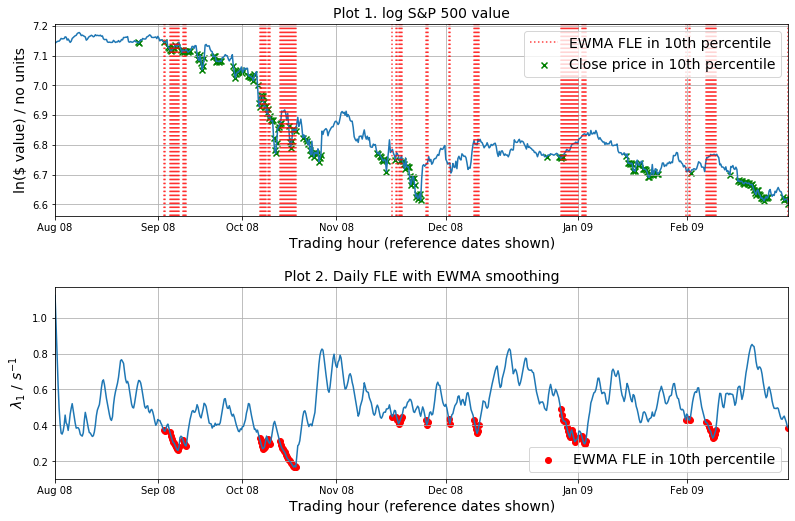

In [34]:
fig, axs = plt.subplots(2,figsize = [12,8])
fig.tight_layout(pad=5.0)
    
######### 1) Plot log returns #########
    
axs[0].set_title('Plot 1. log S&P 500 value', fontsize = 14)    
axs[0].set_ylabel('ln($ value) / no units', fontsize = 14)
axs[0].plot( plot_data.index.values,np.log(plot_data['OPEN']))

######### 2) Plot FLE_smoothed #########

axs[1].set_title('Plot 2. Daily FLE with EWMA smoothing', fontsize = 14)
axs[1].set_ylabel('$\lambda_1$ / $s^{-1}$', fontsize = 14)
axs[1].plot(plot_data.index.values, plot_data['FLE_smoothed'])

######### Plot Lyapunov in low percentile #########

low_lyapunov_data = plot_data.loc[plot_data['low_lyapunov'] == 1]
low_value_dates = np.array(low_lyapunov_data.index.values)

axs[1].scatter(low_lyapunov_data.index.values , low_lyapunov_data['FLE_smoothed'],label ='EWMA FLE in 10th percentile', c = 'r')

for value in low_value_dates:
    axs[0].axvline(value,c = 'r',alpha = 0.75, linestyle = ':',label ='EWMA FLE in 10th percentile')
    
############# Show crashes ################

crash_df = plot_data.loc[plot_data['crashing'] == 1]
axs[0].scatter(crash_df.index.values,crash_df['ln(close)'],label = 'Close price in 10th percentile', c = 'g', marker = 'x')

############# Legends ################
   
        
handles, labels = axs[0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

axs[0].legend(by_label.values(), by_label.keys(), loc = 'upper right', fontsize = 14)

axs[1].legend(loc = 'lower right', fontsize = 14)    

######### Format axes #########

for ax in axs:
    ax.grid()
    ax.set_xticks(axis_labels['loc'])
    ax.set_xticklabels(axis_labels['marker'].dt.strftime('%b %y'))
    ax.set_xlabel('Trading hour (reference dates shown)', fontsize = 14)
    ax.set_xlim(plot_data.index.values.min(), plot_data.index.values.max())

######### Save #########

fname = 'hourly_2008'
plt.savefig('Figures_for_report/' + fname + '.png', dpi = 400)




### Beginning of financial crisis zoom

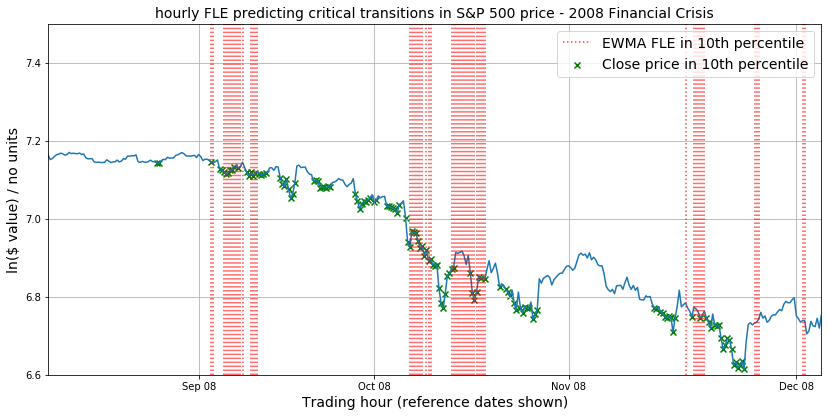

In [36]:

fig, axs = plt.subplots(figsize = [12,6])
fig.tight_layout(pad=3.0)
    
######### 1) Plot log returns #########
    
axs.set_title('hourly FLE predicting critical transitions in S&P 500 price - 2008 Financial Crisis', fontsize = 14)    
axs.set_ylabel('ln($ value) / no units', fontsize = 14)
axs.plot( plot_data.index.values,np.log(plot_data['OPEN']))
axs.set_ylim(6.6,7.5)


for value in low_value_dates:
    axs.axvline(value,c = 'r',alpha = 0.75, linestyle = ':',label ='EWMA FLE in 10th percentile')
    
############# Show crashes ################

crash_df = plot_data.loc[plot_data['crashing'] == 1]
axs.scatter(crash_df.index.values,crash_df['ln(close)'],label = 'Close price in 10th percentile', c = 'g', marker = 'x')

############# Legends ################
   
        
handles, labels = axs.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

axs.legend(by_label.values(), by_label.keys(), loc = 'upper right', fontsize = 14)



######### Format axes #########

axs.grid()
axs.set_xticks(axis_labels['loc'])
axs.set_xticklabels(axis_labels['marker'].dt.strftime('%b %y'))
axs.set_xlabel('Trading hour (reference dates shown)', fontsize = 14)
axs.set_xlim(30, 400)

######### Save #########

fname = 'hourly_sept_oct_2008'
plt.savefig('Figures_for_report/' + fname + '.png', dpi = 400)




### Confusion matrix

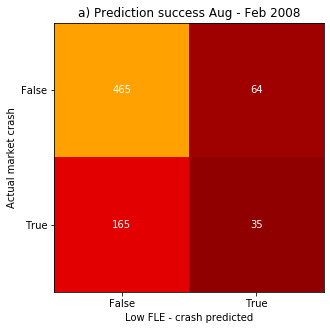

In [22]:
df_confusion = pd.crosstab(plot_data['crashing'], plot_data['low_lyapunov'],  rownames=['Actual'], colnames=['Predicted'])

title='a) Prediction success Aug - Feb 2008'

cmap=plt.cm.get_cmap('hot', 100)
cmap = matplotlib.colors.ListedColormap(cmap(np.linspace(0.2, 0.6, 100)))

fig, ax = plt.subplots(figsize = [5,5])
fig.tight_layout(pad=3.0)
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(df_confusion, cmap=cmap)

for (i, j), z in np.ndenumerate(df_confusion):
    ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center', c = 'w')
    
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('Low FLE - crash predicted')
plt.ylabel('Actual market crash')
plt.title(title)

ax.set_xticklabels(['a','False', 'True'])
ax.set_yticklabels(['a','False', 'True'])

fname = 'Hourly_2008_confusion_matrix'
plt.savefig('Figures_for_report/' + fname + '.png', dpi = 400, bbox_inches = 'tight')

In [23]:
#sensitivity = true positives + (TP + FN)
sensitivity = df_confusion[1][1] / (df_confusion[0][1] + df_confusion[1][1])

#False positive = FP / (TP + FP)
false_positive = df_confusion[1][0] / (df_confusion[1][0] + df_confusion[1][1])

print('Sensitivity is ', sensitivity)
print('False positive rate is ', false_positive)

Sensitivity is  0.175
False positive rate is  0.6464646464646465


## 2019

In [37]:
start = '2019-01-01'
end = '2019-07-01'

plot_data = hourly_FLE_df.loc[(hourly_FLE_df['TIMESTAMP'] >= start) & (hourly_FLE_df['TIMESTAMP'] <= end)].copy()
print(plot_data['TIMESTAMP'].agg(['min','max']))
print()
print("Includes " , plot_data['TIMESTAMP'].dt.date.nunique(), " days over ", plot_data.shape[0], "indices.")


min   2019-01-03 10:00:00
max   2019-06-28 16:00:00
Name: TIMESTAMP, dtype: datetime64[ns]

Includes  121  days over  923 indices.


In [38]:
smoothing_hl = 10
quantile_window = 80 
quantile_value = 0.1

plot_data['FLE_smoothed'] = plot_data['lyapunov_exponent'].ewm(halflife=smoothing_hl).mean()
plot_data['threshold'] = plot_data['FLE_smoothed'].rolling(quantile_window).quantile(quantile_value)
plot_data['low_lyapunov'] = np.where(plot_data['FLE_smoothed'] <plot_data['threshold'], 1 ,0)

In [39]:
axis_labels = pd.DataFrame(columns = ['loc','marker'])
axis_labels['marker'] = plot_data.groupby(plot_data['TIMESTAMP'].dt.month).first()['TIMESTAMP'].sort_values()
axis_labels['loc'] = plot_data.loc[plot_data['TIMESTAMP'].isin(axis_labels['marker'])].index.sort_values()

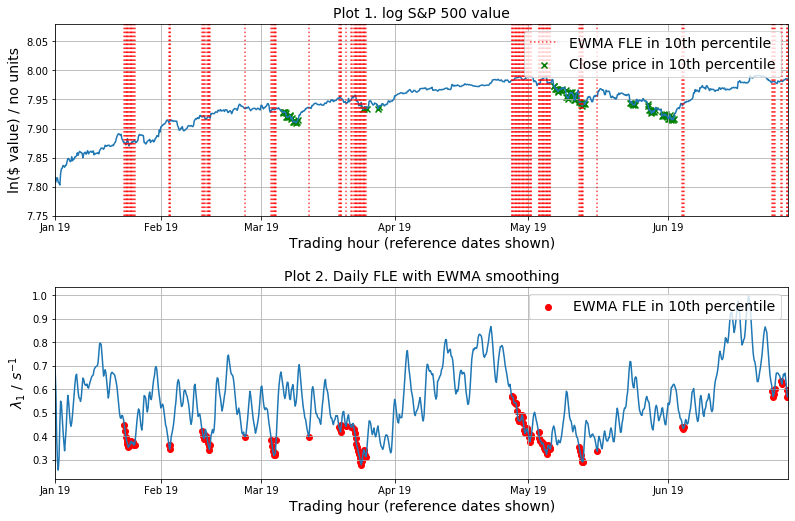

In [40]:
fig, axs = plt.subplots(2,figsize = [12,8])
fig.tight_layout(pad=5.0)
    
######### 1) Plot log returns #########
    
axs[0].set_title('Plot 1. log S&P 500 value', fontsize = 14)    
axs[0].set_ylabel('ln($ value) / no units', fontsize = 14)
axs[0].plot( plot_data.index.values,np.log(plot_data['OPEN']))
axs[0].set_ylim(7.75,8.08)

######### 2) Plot FLE_smoothed #########
axs[1].set_title('Plot 2. Daily FLE with EWMA smoothing', fontsize = 14)
axs[1].set_ylabel('$\lambda_1$ / $s^{-1}$', fontsize = 14)
axs[1].plot(plot_data.index.values, plot_data['FLE_smoothed'])

######### Plot Lyapunov in low percentile #########

low_lyapunov_data = plot_data.loc[plot_data['low_lyapunov'] == 1]
low_value_dates = np.array(low_lyapunov_data.index.values)

axs[1].scatter(low_lyapunov_data.index.values , low_lyapunov_data['FLE_smoothed'],label ='EWMA FLE in 10th percentile', c = 'r')

for value in low_value_dates:
    axs[0].axvline(value,c = 'r',alpha = 0.75, linestyle = ':',label ='EWMA FLE in 10th percentile')
    
############# Show crashes ################

crash_df = plot_data.loc[plot_data['crashing'] == 1]
axs[0].scatter(crash_df.index.values,crash_df['ln(close)'],label = 'Close price in 10th percentile', c = 'g', marker = 'x')

############# Legends ################
   
        
handles, labels = axs[0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

axs[0].legend(by_label.values(), by_label.keys(), loc = 'upper right', fontsize = 14)

axs[1].legend(loc = 'upper right', fontsize = 14)    

######### Format axes #########

for ax in axs:
    ax.grid()
    ax.set_xticks(axis_labels['loc'])
    ax.set_xticklabels(axis_labels['marker'].dt.strftime('%b %y'))
    ax.set_xlabel('Trading hour (reference dates shown)', fontsize = 14)
    ax.set_xlim(plot_data.index.values.min(), plot_data.index.values.max())

######### Save #########

fname = 'hourly_2019'
plt.savefig('Figures_for_report/' + fname + '.png', dpi =400)




### Beginning of financial crisis zoom

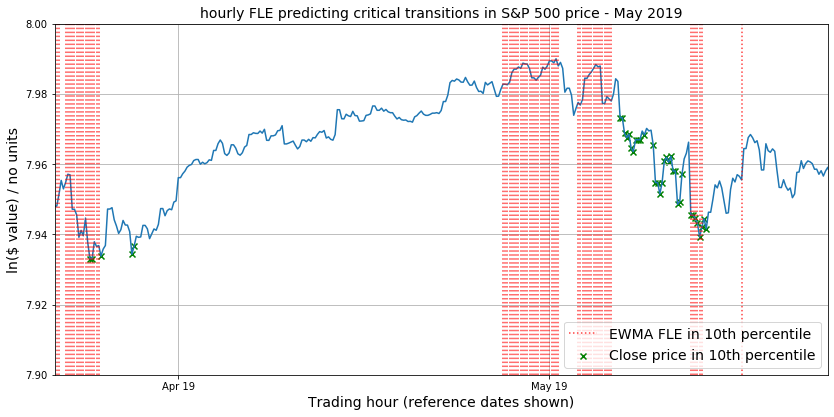

In [41]:
fig, axs = plt.subplots(figsize = [12,6])
fig.tight_layout(pad=3.0)
    
######### 1) Plot log returns #########
    
axs.set_title('hourly FLE predicting critical transitions in S&P 500 price - May 2019', fontsize = 14)    
axs.set_ylabel('ln($ value) / no units', fontsize = 14)
axs.plot( plot_data.index.values,np.log(plot_data['OPEN']))
axs.set_ylim(7.9,8)


for value in low_value_dates:
    axs.axvline(value,c = 'r',alpha = 0.75, linestyle = ':',label ='EWMA FLE in 10th percentile')
    
############# Show crashes ################

crash_df = plot_data.loc[plot_data['crashing'] == 1]
axs.scatter(crash_df.index.values,crash_df['ln(close)'],label = 'Close price in 10th percentile', c = 'g', marker = 'x')

############# Legends ################
   
        
handles, labels = axs.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

axs.legend(by_label.values(), by_label.keys(), loc = 'lower right', fontsize = 14)



######### Format axes #########

axs.grid()
axs.set_xticks(axis_labels['loc'])
axs.set_xticklabels(axis_labels['marker'].dt.strftime('%b %y'))
axs.set_xlabel('Trading hour (reference dates shown)', fontsize = 14)
axs.set_xlim(1100,1450)

######### Save #########

fname = 'hourly_may_2018'
plt.savefig('Figures_for_report/' + fname + '.png', dpi = 400)




### Confusion matrix

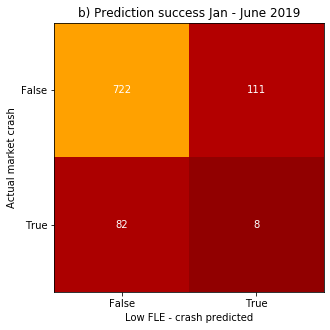

In [28]:
df_confusion = pd.crosstab(plot_data['crashing'], plot_data['low_lyapunov'],  rownames=['Actual'], colnames=['Predicted'])

title='b) Prediction success Jan - June 2019'

cmap=plt.cm.get_cmap('hot', 100)
cmap = matplotlib.colors.ListedColormap(cmap(np.linspace(0.2, 0.6, 100)))

fig, ax = plt.subplots(figsize = [5,5])
fig.tight_layout(pad=3.0)
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(df_confusion, cmap=cmap)

for (i, j), z in np.ndenumerate(df_confusion):
    ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center', c = 'w')
    
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('Low FLE - crash predicted')
plt.ylabel('Actual market crash')
plt.title(title)

ax.set_xticklabels(['a','False', 'True'])
ax.set_yticklabels(['a','False', 'True'])

fname = 'Hourly_2019_confusion_matrix'
plt.savefig('Figures_for_report/' + fname + '.png', dpi = 400, bbox_inches = 'tight')

In [29]:
#sensitivity = true positives + (TP + FN)
sensitivity = df_confusion[1][1] / (df_confusion[0][1] + df_confusion[1][1])

#False positive = FP / (TP + FP)
false_positive = df_confusion[1][0] / (df_confusion[1][0] + df_confusion[1][1])

print('Sensitivity is ', sensitivity)
print('False positive rate is ', false_positive)

Sensitivity is  0.08888888888888889
False positive rate is  0.9327731092436975
